# <center>Mortality Prediction</center>

### Importing Packges

In [3]:
import pandas as pd
import numpy as np
import psycopg2
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb

%matplotlib inline

### Establising connection to Redshift to fetch Master Data

In [154]:
# Database connection parameters
db_name = 'factihealth'   # Database name
db_user = 'fh_user'  # Username
db_password = 'Facti@874'  # Password
db_host = 'redshift-cluster-factihealth.cuzgotkwtow6.ap-south-1.redshift.amazonaws.com'  # Cluster endpoint
db_port = 5439  # Port
# Connect to the database
try:
    conn = psycopg2.connect(
        dbname=db_name,
        user=db_user,
        password=db_password,
        host=db_host,
        port=db_port
    )
    print("Connected to the database successfully")
    # Create a cursor object
    cur = conn.cursor()
    # Execute a query
    cur.execute('''with patients as 
(
select distinct a.subject_id
from factihealth.mimic.ecg_model_dataset a
inner join factihealth.mimic.mortality_data b on a.subject_id=b.subject_id
where date_part(year,edadmittime) = 2130
and date_part(month,edadmittime) in (04,05,06)
and date_part(year,ecgtime) = 2130
and date_part(month,ecgtime) in (04,05,06)
order by ecgtime,a.subject_id 
)
SELECT
    *,
    to_date(REPLACE(edadmittime,'2130','2023'),'YYYY-MM-DD') edadmit_time
FROM
    factihealth.mimic.mortality_data
WHERE
    subject_id IN (SELECT * FROM patients)
    AND date_part('year', edadmittime) = 2130
    AND date_part('month', edadmittime) in (04,05,06)''')
    # Fetch the result
    rows = cur.fetchall()

    # Get the column names
    column_names = [desc[0] for desc in cur.description]

    # Create a DataFrame
    master_data = pd.DataFrame(rows, columns=column_names)

    print('Dataframe shape:', master_data.shape)
    # Fetch and print the result
except Exception as e:
    print(f"Database connection failed due to {e}")

Connected to the database successfully
Dataframe shape: (73, 28)


### EDA and Feature Engg.

In [81]:
master_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 28 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   subject_id                             37 non-null     int64  
 1   hadm_id                                37 non-null     int64  
 2   edadmittime                            37 non-null     object 
 3   age                                    37 non-null     int64  
 4   age_bucket                             37 non-null     object 
 5   gender                                 37 non-null     object 
 6   ethnicity                              37 non-null     object 
 7   ethnicity_combined                     37 non-null     object 
 8   admission_type                         37 non-null     object 
 9   admission_type_combined                37 non-null     object 
 10  first_careunit                         37 non-null     object 
 11  first_ca

In [6]:
master_data.describe()

,subject_id,hadm_id,age,icu_los,hospital_expire_flag,heart_rate_mean,gcs_eye_opening,gcs_verbal_response,gcs_motor_response,non_invasive_blood_pressure_diastolic,non_invasive_blood_pressure_mean,respiratory_rate,temperature_fahrenheit,height_cm,admission_weight_lbs,mixed_venous_o2_sat,o2_saturation_pulseoxymetry2,ph_dipstick
count,7.318100e+04,7.318100e+04,73181.000000,73181.000000,73181.000000,73179.000000,73014.000000,73007.000000,72999.000000,72486.000000,72485.000000,73125.000000,72298.000000,3.829800e+04,61367.000000,8290.000000,73121.000000,25459.000000
mean,1.499819e+07,2.498133e+07,63.196485,3.451931,0.113814,85.817218,3.527048,3.914458,5.530349,66.413301,92.764332,19.491686,98.518783,2.234996e+02,180.114727,558.396347,102.799583,183.403198
std,2.886067e+06,2.884400e+06,16.850717,4.922840,0.317587,381.460020,0.642237,1.296507,0.900711,54.525552,1702.510247,64.458603,39.981779,1.070785e+04,137.811766,19810.587318,892.745852,10255.101589
min,1.000003e+07,2.000009e+07,18.000000,0.001250,0.000000,-495.975669,1.000000,1.000000,1.000000,14.500000,24.666667,2.000000,0.000000,0.000000e+00,0.000000,16.000000,35.000000,0.000000
25%,1.249126e+07,2.248335e+07,53.000000,1.084225,0.000000,74.480000,3.314961,3.066667,5.400000,57.562500,70.504505,16.764706,97.950001,1.630000e+02,144.300003,62.200000,95.625000,7.330000
50%,1.499894e+07,2.496964e+07,65.000000,1.926782,0.000000,83.588235,3.750000,4.466667,6.000000,64.326252,77.375000,18.816901,98.287499,1.700000e+02,171.800003,68.750000,96.783784,7.380000
75%,1.751327e+07,2.747180e+07,76.000000,3.713322,0.000000,93.666667,4.000000,5.000000,6.000000,71.915789,85.336538,21.261682,98.680000,1.780000e+02,204.600006,76.000000,97.860465,7.420000
max,1.999999e+07,2.999983e+07,91.000000,110.232280,1.000000,103185.164948,4.000000,5.000000,6.000000,6447.769231,247013.250000,17340.558824,7647.574193,2.095680e+06,22086.349998,999999.000000,217103.911111,999999.000000


In [7]:
data=master_data.copy()

In [8]:
# dropping columns which are not required
data.drop(['mixed_venous_o2_sat','ph_dipstick','icu_los','age_bucket','ethnicity','admission_type','first_careunit'],axis = 1, inplace = True)

# Cleaning the data by adding limits to remove unrealistic data due to human/techincal errors

condition_1 = data['non_invasive_blood_pressure_diastolic'] > 200
data.loc[condition_1, 'non_invasive_blood_pressure_diastolic'] = data.loc[condition_1, 'non_invasive_blood_pressure_mean']
data = data[(data['heart_rate_mean'] >= 0) & (data['heart_rate_mean'] <= 500)]
data = data[(data['respiratory_rate'] >= 0) & (data['respiratory_rate'] <= 100)]
data = data[(data['temperature_fahrenheit'] >= 0) & (data['temperature_fahrenheit'] <= 250)]
data = data[(data['admission_weight_lbs'] >= 0) & (data['admission_weight_lbs'] <= 1000)]
data = data[(data['o2_saturation_pulseoxymetry2'] >= 0) & (data['o2_saturation_pulseoxymetry2'] <= 100)]
data = data[(data['height_cm'] >= 0) & (data['height_cm'] <= 300)]

data.drop(['non_invasive_blood_pressure_mean'],axis = 1, inplace = True)

In [64]:
data.to_csv('new_data_to_test_model.csv')

In [7]:
df = data.copy()
# Apply one-hot encoding
df_encoded = pd.get_dummies(df, columns=['admission_type_combined', 'first_careunit_combined','ethnicity_combined','gender'])
df_encoded.head()

,subject_id,hadm_id,age,hospital_expire_flag,heart_rate_mean,gcs_eye_opening,gcs_verbal_response,gcs_motor_response,non_invasive_blood_pressure_diastolic,respiratory_rate,...,ethnicity_combined_ASIAN,ethnicity_combined_BLACK/AFRICAN,ethnicity_combined_HISPANIC OR LATINO,ethnicity_combined_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,ethnicity_combined_OTHER,ethnicity_combined_PORTUGUESE,ethnicity_combined_SOUTH AMERICAN,ethnicity_combined_WHITE,gender_F,gender_M
0,18106347,24305596,48,0,98.945946,3.000000,3.000000,4.750000,62.444444,14.702703,...,0,0,0,0,0,0,0,1,1,0
2,13201095,28453791,88,1,100.858209,3.051282,1.333333,3.820513,52.846154,22.299611,...,0,0,0,0,1,0,0,0,1,0
7,10582595,20690213,91,0,92.237500,3.441176,4.705882,5.823529,59.629032,16.075000,...,0,0,0,0,0,0,0,1,1,0
10,13721591,20342223,65,0,76.126050,3.666667,2.600000,5.833333,65.405172,23.428571,...,0,0,0,0,0,0,0,1,1,0
12,18218721,20122533,73,0,83.166667,3.588235,3.470588,5.444444,65.111111,19.200000,...,0,0,0,0,0,0,0,1,1,0


In [8]:
# calculating fill rate of each column
fill_rates = df_encoded.count() / len(df_encoded) * 100
fill_rates

subject_id                                                      100.000000
hadm_id                                                         100.000000
age                                                             100.000000
hospital_expire_flag                                            100.000000
heart_rate_mean                                                 100.000000
gcs_eye_opening                                                  99.966875
gcs_verbal_response                                              99.969635
gcs_motor_response                                               99.961354
non_invasive_blood_pressure_diastolic                            99.224314
respiratory_rate                                                100.000000
temperature_fahrenheit                                          100.000000
height_cm                                                       100.000000
admission_weight_lbs                                            100.000000
o2_saturation_pulseoxymet

In [9]:
mean_value = df_encoded['non_invasive_blood_pressure_diastolic'].mean()

# Replace NaNs in the column with the calculated mean value
df_encoded['non_invasive_blood_pressure_diastolic'].fillna(mean_value, inplace=True)
df_encoded['gcs_eye_opening'].fillna(0, inplace=True)
df_encoded['gcs_verbal_response'].fillna(0, inplace=True)
df_encoded['gcs_motor_response'].fillna(0, inplace=True)

In [10]:
nan_per_column = df_encoded.isnull().sum()
print("NaNs in each column:\n", nan_per_column)

NaNs in each column:
 subject_id                                                      0
hadm_id                                                         0
age                                                             0
hospital_expire_flag                                            0
heart_rate_mean                                                 0
gcs_eye_opening                                                 0
gcs_verbal_response                                             0
gcs_motor_response                                              0
non_invasive_blood_pressure_diastolic                           0
respiratory_rate                                                0
temperature_fahrenheit                                          0
height_cm                                                       0
admission_weight_lbs                                            0
o2_saturation_pulseoxymetry2                                    0
admission_type_combined_Elective                      

In [11]:
np.shape(df_encoded)

(36226, 33)

In [12]:
df_encoded.head()

,subject_id,hadm_id,age,hospital_expire_flag,heart_rate_mean,gcs_eye_opening,gcs_verbal_response,gcs_motor_response,non_invasive_blood_pressure_diastolic,respiratory_rate,...,ethnicity_combined_ASIAN,ethnicity_combined_BLACK/AFRICAN,ethnicity_combined_HISPANIC OR LATINO,ethnicity_combined_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,ethnicity_combined_OTHER,ethnicity_combined_PORTUGUESE,ethnicity_combined_SOUTH AMERICAN,ethnicity_combined_WHITE,gender_F,gender_M
0,18106347,24305596,48,0,98.945946,3.000000,3.000000,4.750000,62.444444,14.702703,...,0,0,0,0,0,0,0,1,1,0
2,13201095,28453791,88,1,100.858209,3.051282,1.333333,3.820513,52.846154,22.299611,...,0,0,0,0,1,0,0,0,1,0
7,10582595,20690213,91,0,92.237500,3.441176,4.705882,5.823529,59.629032,16.075000,...,0,0,0,0,0,0,0,1,1,0
10,13721591,20342223,65,0,76.126050,3.666667,2.600000,5.833333,65.405172,23.428571,...,0,0,0,0,0,0,0,1,1,0
12,18218721,20122533,73,0,83.166667,3.588235,3.470588,5.444444,65.111111,19.200000,...,0,0,0,0,0,0,0,1,1,0


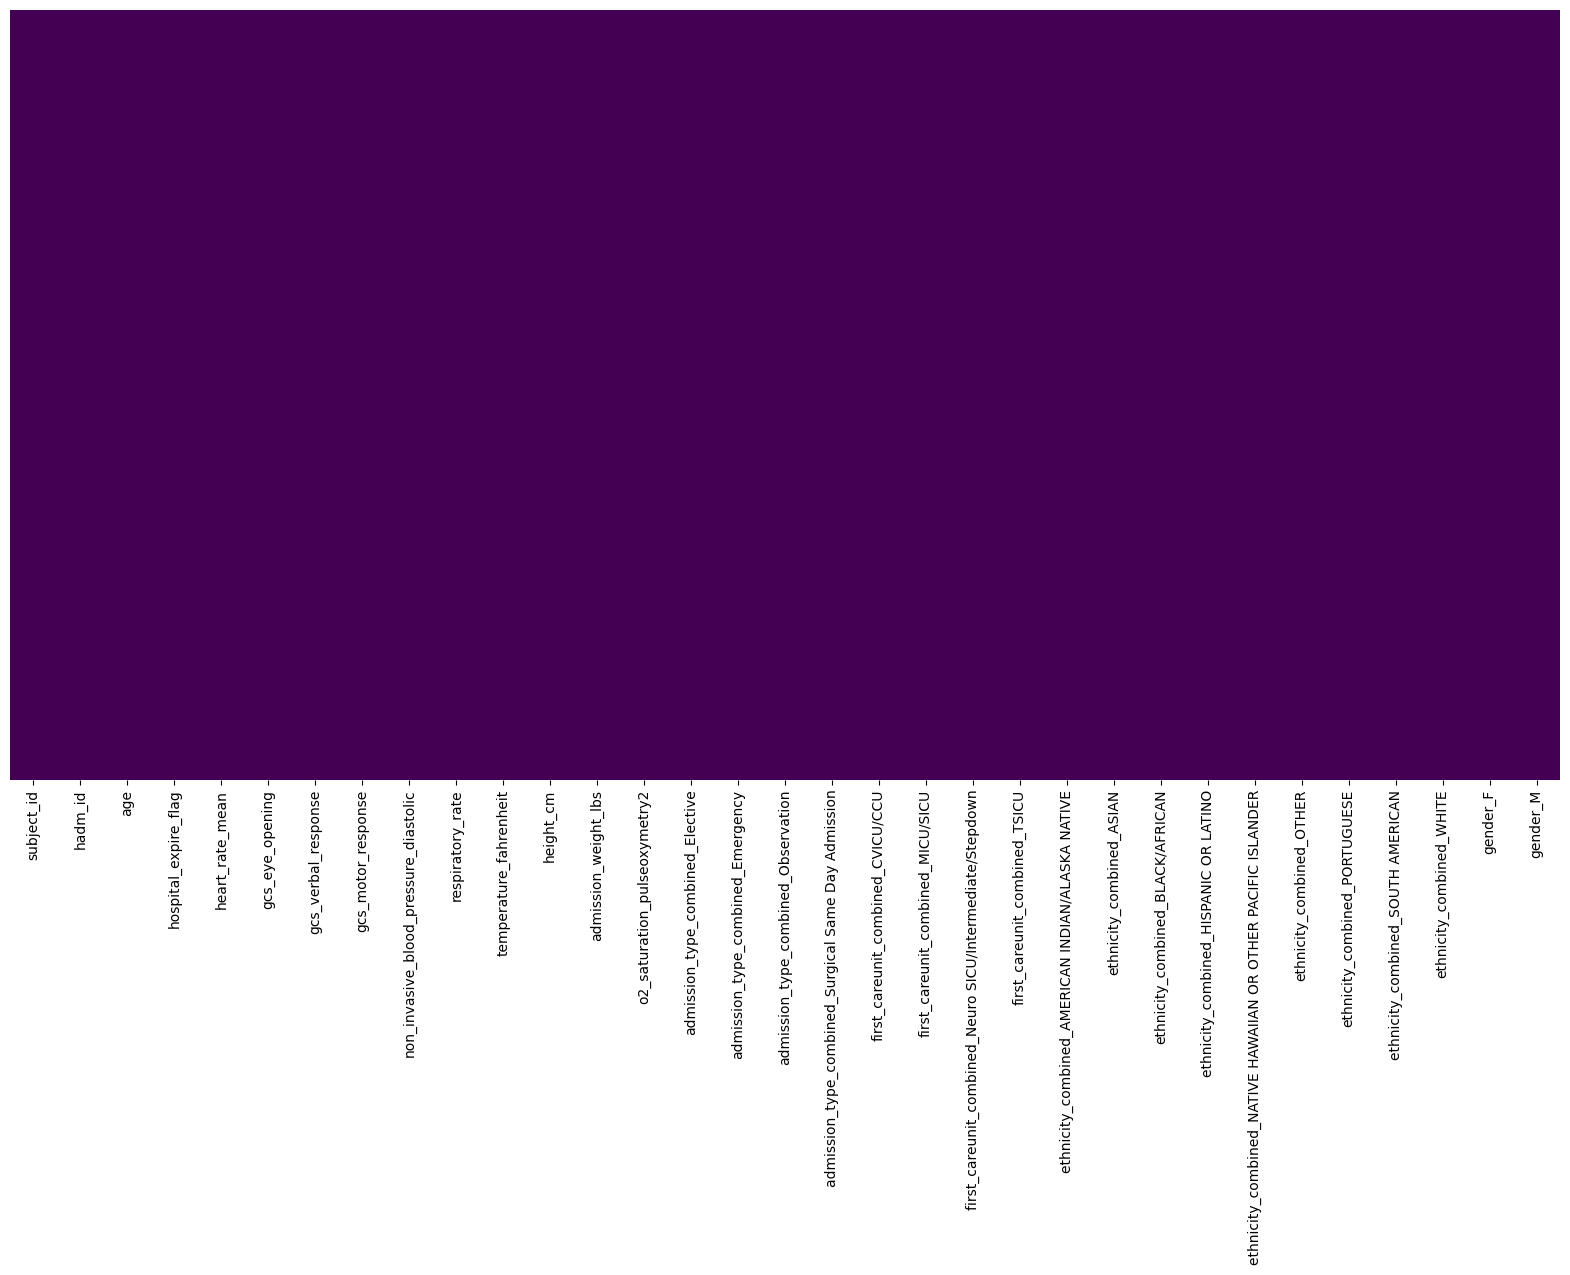

In [13]:
plt.figure(figsize=(20, 10)) 
sns.heatmap(df_encoded.isnull(), yticklabels = False, cbar = False, cmap='viridis')
plt.xticks(rotation=90)
plt.show()

In [14]:
;df_encoded.drop(columns=['subject_id','hadm_id'],inplace = True)

In [15]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36226 entries, 0 to 73180
Data columns (total 31 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   age                                                           36226 non-null  int64  
 1   hospital_expire_flag                                          36226 non-null  int64  
 2   heart_rate_mean                                               36226 non-null  float64
 3   gcs_eye_opening                                               36226 non-null  float64
 4   gcs_verbal_response                                           36226 non-null  float64
 5   gcs_motor_response                                            36226 non-null  float64
 6   non_invasive_blood_pressure_diastolic                         36226 non-null  float64
 7   respiratory_rate                                              36226

In [16]:
df_encoded.head()

,age,hospital_expire_flag,heart_rate_mean,gcs_eye_opening,gcs_verbal_response,gcs_motor_response,non_invasive_blood_pressure_diastolic,respiratory_rate,temperature_fahrenheit,height_cm,...,ethnicity_combined_ASIAN,ethnicity_combined_BLACK/AFRICAN,ethnicity_combined_HISPANIC OR LATINO,ethnicity_combined_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,ethnicity_combined_OTHER,ethnicity_combined_PORTUGUESE,ethnicity_combined_SOUTH AMERICAN,ethnicity_combined_WHITE,gender_F,gender_M
0,48,0,98.945946,3.000000,3.000000,4.750000,62.444444,14.702703,99.000000,166.0,...,0,0,0,0,0,0,0,1,1,0
2,88,1,100.858209,3.051282,1.333333,3.820513,52.846154,22.299611,99.587692,163.0,...,0,0,0,0,1,0,0,0,1,0
7,91,0,92.237500,3.441176,4.705882,5.823529,59.629032,16.075000,97.960714,163.0,...,0,0,0,0,0,0,0,1,1,0
10,65,0,76.126050,3.666667,2.600000,5.833333,65.405172,23.428571,98.800000,163.0,...,0,0,0,0,0,0,0,1,1,0
12,73,0,83.166667,3.588235,3.470588,5.444444,65.111111,19.200000,97.992307,160.0,...,0,0,0,0,0,0,0,1,1,0


Note:
df_encoded is the final dataset that will be used for modelling

# Model: Random Forest

In [17]:
X = df_encoded.drop('hospital_expire_flag', axis=1)
y = df_encoded['hospital_expire_flag']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [20]:
y_pred = rf_classifier.predict(X_test)

[[6226   80]
 [ 364  576]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      6306
           1       0.88      0.61      0.72       940

    accuracy                           0.94      7246
   macro avg       0.91      0.80      0.84      7246
weighted avg       0.94      0.94      0.93      7246

Accuracy: 0.9387248136903119


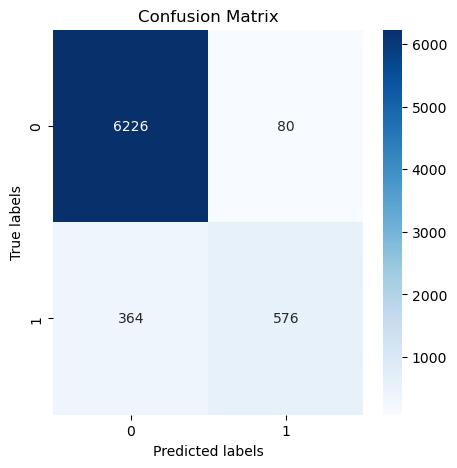

In [21]:
# Evaluating the Algorithm
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

# Creating a heatmap from the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [22]:
probabilities = rf_classifier.predict_proba(X_test)

In [23]:
# To get the probablibily scores for 0's and 1's
class_names = rf_classifier.classes_
probabilities_df = pd.DataFrame(probabilities, columns=['Y_0','Y_1'])
probabilities_df.head()

,Y_0,Y_1
0,1.00,0.00
1,0.94,0.06
2,0.96,0.04
3,1.00,0.00
4,0.33,0.67


In [24]:
pred_dataset_reset = y_test.reset_index()
pred_dataset_reset.rename(columns={'hospital_expire_flag': 'y_test'}, inplace=True)
pred_dataset_reset['Y_pred']=y_pred
pred_dataset_reset['Y_prob_1']=probabilities_df['Y_1']
pred_dataset_reset['Y_prob_0']=probabilities_df['Y_0']
pred_dataset_reset

,index,y_test,Y_pred,Y_prob_1,Y_prob_0
0,54070,0,0,0.00,1.00
1,6254,0,0,0.06,0.94
2,13607,0,0,0.04,0.96
3,37282,0,0,0.00,1.00
4,11918,1,1,0.67,0.33
...,...,...,...,...,...
7241,14102,0,0,0.04,0.96
7242,63044,0,0,0.01,0.99
7243,59641,0,0,0.03,0.97
7244,52030,1,1,0.73,0.27


In [26]:
# Extract feature importances
feature_importances = rf_classifier.feature_importances_

# Convert the importances into a DataFrame
feature_importances_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importances})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)

# Display the feature importances
print(feature_importances_df)

                                              feature  importance
3                                 gcs_verbal_response    0.135102
2                                     gcs_eye_opening    0.127634
4                                  gcs_motor_response    0.114585
10                       o2_saturation_pulseoxymetry2    0.092542
7                              temperature_fahrenheit    0.078409
1                                     heart_rate_mean    0.077099
5               non_invasive_blood_pressure_diastolic    0.074447
6                                    respiratory_rate    0.071767
0                                                 age    0.056189
9                                admission_weight_lbs    0.055348
8                                           height_cm    0.038156
15                  first_careunit_combined_CVICU/CCU    0.010495
16                  first_careunit_combined_MICU/SICU    0.010037
27                           ethnicity_combined_WHITE    0.006945
29        

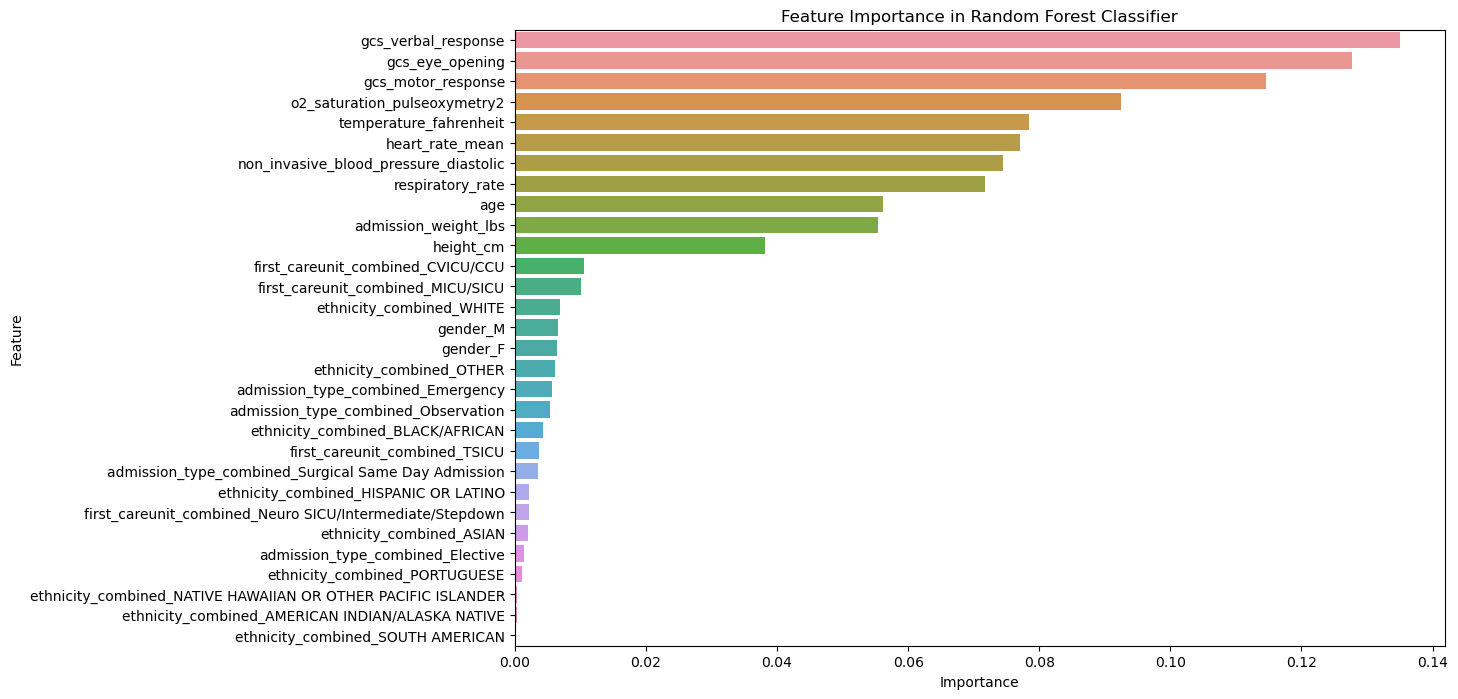

In [27]:
# Plotting feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances_df)
plt.title('Feature Importance in Random Forest Classifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [28]:
# Remove gender, ethnicity and first care unit

##### Recreating the test_data with the predictions as 0's, 1's and probability values

In [29]:
df_reset = df.reset_index()
df_reset.rename(columns={'index': 'index'}, inplace=True)

In [30]:
df_reset.head()

,index,subject_id,hadm_id,age,gender,ethnicity_combined,admission_type_combined,first_careunit_combined,hospital_expire_flag,heart_rate_mean,gcs_eye_opening,gcs_verbal_response,gcs_motor_response,non_invasive_blood_pressure_diastolic,respiratory_rate,temperature_fahrenheit,height_cm,admission_weight_lbs,o2_saturation_pulseoxymetry2
0,0,18106347,24305596,48,F,WHITE,Emergency,CVICU/CCU,0,98.945946,3.000000,3.000000,4.750000,62.444444,14.702703,99.000000,166.0,211.600006,97.648649
1,2,13201095,28453791,88,F,OTHER,Emergency,CVICU/CCU,1,100.858209,3.051282,1.333333,3.820513,52.846154,22.299611,99.587692,163.0,158.199997,96.867521
2,7,10582595,20690213,91,F,WHITE,Emergency,MICU/SICU,0,92.237500,3.441176,4.705882,5.823529,59.629032,16.075000,97.960714,163.0,119.500000,96.748428
3,10,13721591,20342223,65,F,WHITE,Emergency,MICU/SICU,0,76.126050,3.666667,2.600000,5.833333,65.405172,23.428571,98.800000,163.0,244.899994,95.034188
4,12,18218721,20122533,73,F,WHITE,Surgical Same Day Admission,CVICU/CCU,0,83.166667,3.588235,3.470588,5.444444,65.111111,19.200000,97.992307,160.0,184.600006,93.416667


In [31]:
result = pd.merge(pred_dataset_reset,df_reset, on='index', how='inner')

In [32]:
result.drop(columns=['index'],inplace= True)
result.head()

,y_test,Y_pred,Y_prob_1,Y_prob_0,subject_id,hadm_id,age,gender,ethnicity_combined,admission_type_combined,...,heart_rate_mean,gcs_eye_opening,gcs_verbal_response,gcs_motor_response,non_invasive_blood_pressure_diastolic,respiratory_rate,temperature_fahrenheit,height_cm,admission_weight_lbs,o2_saturation_pulseoxymetry2
0,0,0,0.00,1.00,10371495,25153595,71,F,WHITE,Surgical Same Day Admission,...,82.723404,3.400000,4.200000,5.000000,57.750000,18.106383,97.750000,160.0,201.500000,96.934783
1,0,0,0.06,0.94,10949259,26129263,74,M,WHITE,Emergency,...,74.952381,3.728395,4.987654,5.987654,65.000000,15.202381,97.861111,173.0,226.199997,95.772152
2,0,0,0.04,0.96,17278325,27248171,91,F,WHITE,Emergency,...,81.650000,4.000000,5.000000,6.000000,49.862069,19.866667,99.191667,160.0,159.899994,94.868852
3,0,0,0.00,1.00,11207146,26571512,80,F,OTHER,Emergency,...,86.914286,3.416667,3.416667,5.000000,60.842105,15.676923,97.769231,168.0,183.300003,96.771429
4,1,1,0.67,0.33,15860886,21019750,67,M,WHITE,Emergency,...,89.447115,2.163934,1.000000,3.663934,59.470588,26.000000,100.525000,180.0,220.000000,98.379808


In [33]:
np.shape(result)

(7246, 22)

In [34]:
result.to_csv('results.csv',index=False)

# Model: Random Forest - Hyper Tuned

In [37]:
X = df_encoded.drop('hospital_expire_flag', axis=1)
y = df_encoded['hospital_expire_flag']

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
    # Add other parameters here
}

# Create a base RandomForest model
rf = RandomForestClassifier(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score from the grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found: ", best_params)
print("Best accuracy found: ", best_score)

# Use the best estimator to make predictions
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with best parameters:", accuracy)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters found:  {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best accuracy found:  0.9353347135955832
Accuracy with best parameters: 0.9383107921611924


# Model: XG Boost model

In [38]:
X = df_encoded.drop('hospital_expire_flag', axis=1)
y = df_encoded['hospital_expire_flag']

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate an XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Fit the classifier to the training set
xgb_classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = xgb_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9314104333425338


# Model: XG Boost - Hyper Tuned

In [24]:
X = data.drop('hospital_expire_flag', axis=1)
y = data['hospital_expire_flag']

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5,8],
    # Add other parameters here
}

# Create a base model
xgb_classifier = xgb.XGBClassifier(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

KeyError: "['hospital_expire_flag'] not found in axis"

In [59]:
best_model = grid_search.best_estimator_

# Predict the labels on the test set
y_pred = best_model.predict(X_test)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[6182  124]
 [ 278  662]]


In [61]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      6306
           1       0.84      0.70      0.77       940

    accuracy                           0.94      7246
   macro avg       0.90      0.84      0.87      7246
weighted avg       0.94      0.94      0.94      7246



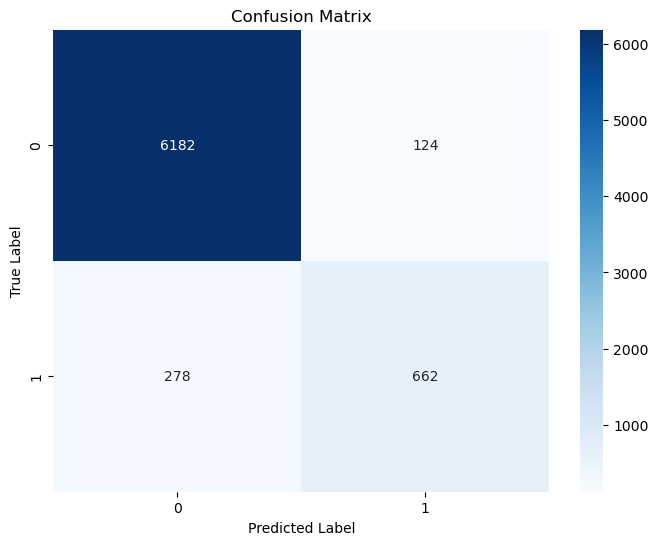

In [60]:

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Creating .pkl file

In [41]:
import pickle

In [46]:
# Save the model to disk
filename = 'icu_patients_mortality_prediction.pkl'  # Change this path if you need to save it elsewhere
pickle.dump(grid_search.best_estimator_, open(filename, 'wb'))

print(f"Model saved to {filename}")

Model saved to icu_patients_mortality_prediction.pkl


[17:47:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[17:47:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


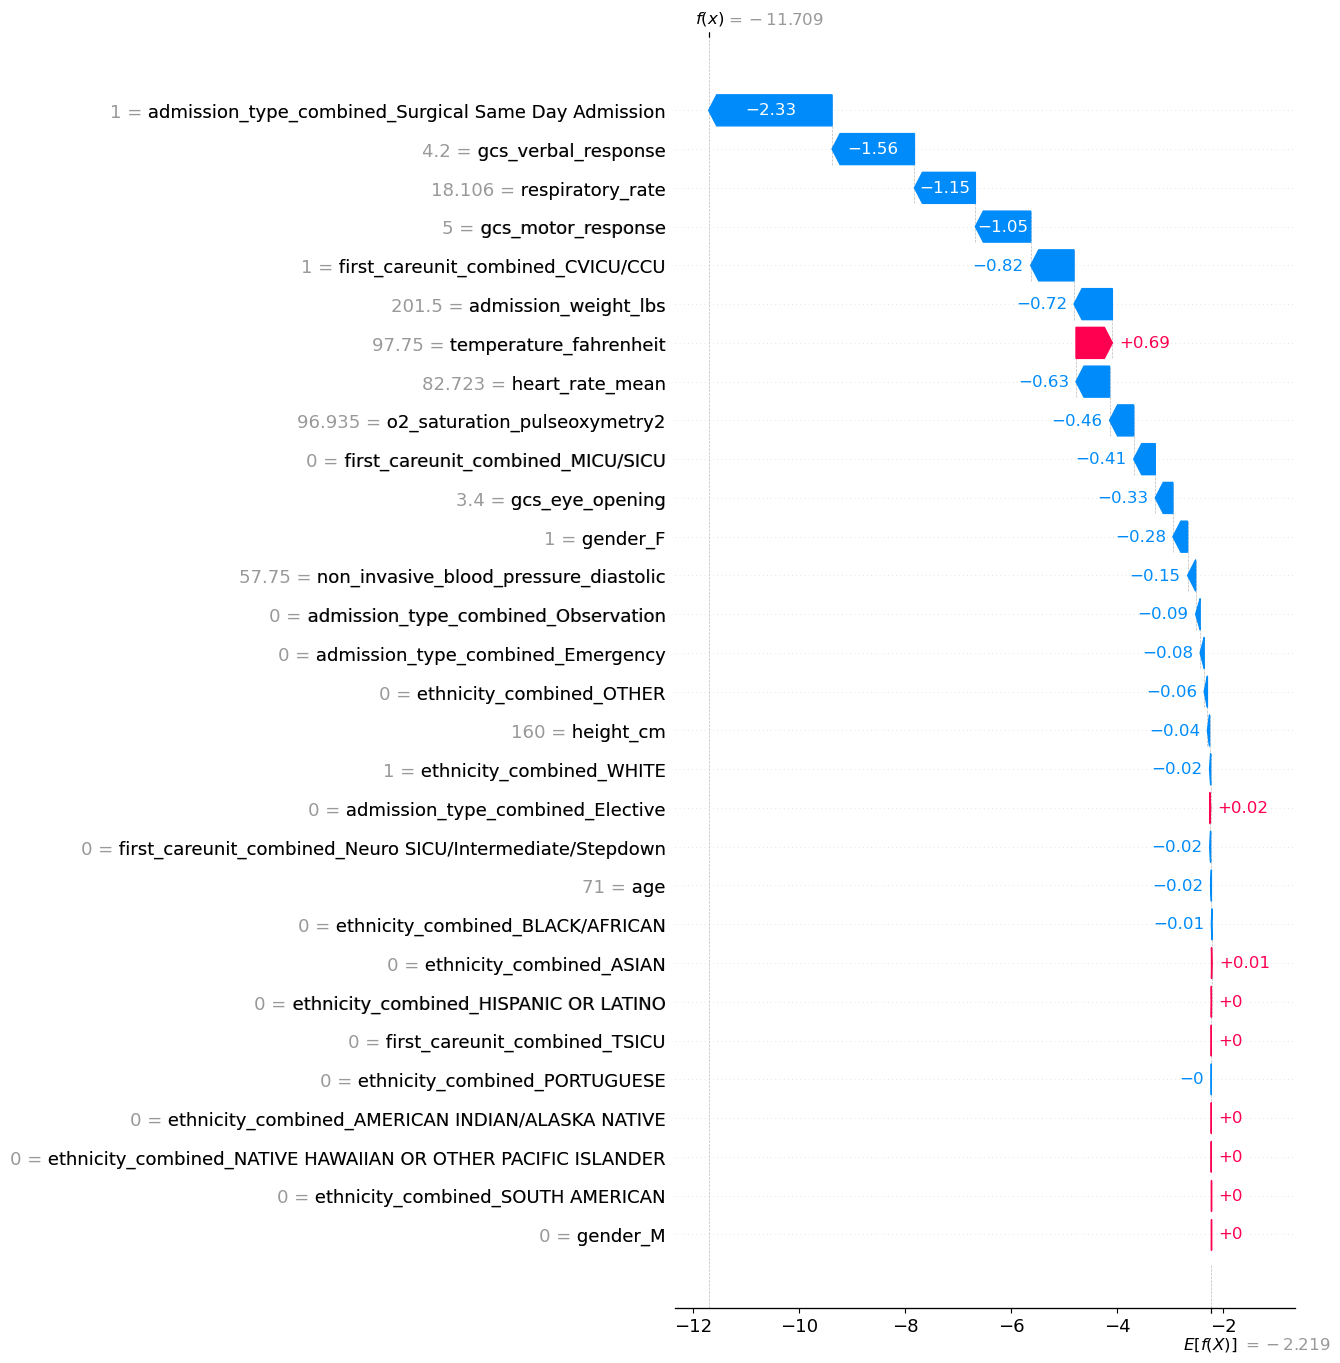

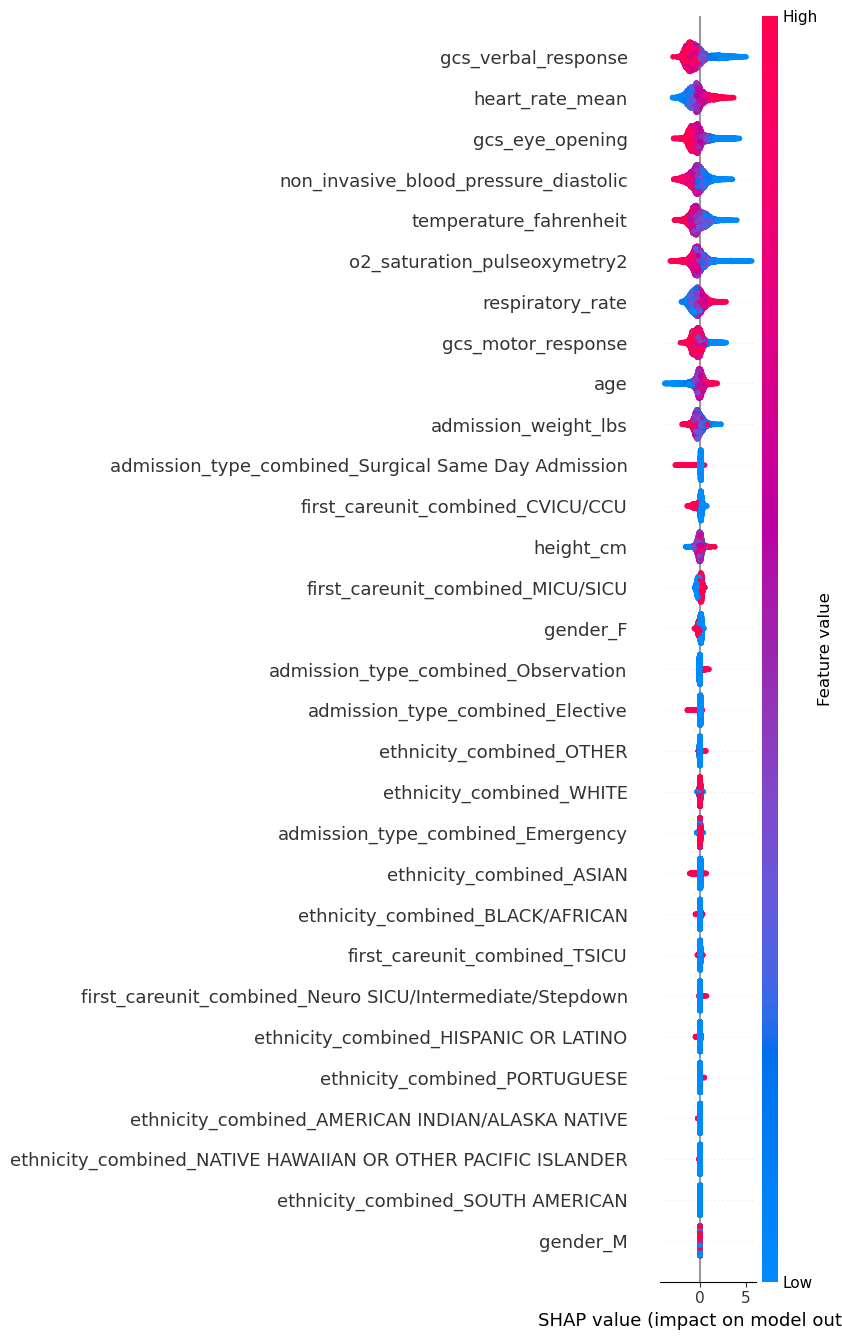

In [66]:
import xgboost as xgb
import shap

# Initialize the XGBoost Classifier with the best parameters found
best_params = grid_search.best_params_
model = xgb.XGBClassifier(**best_params)
model.fit(X_train, y_train)

# Explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, and sklearn models)
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Visualize the first prediction's explanation
plt.figure()
shap.plots.waterfall(shap_values[0], max_display=len(X_test.columns))
plt.savefig('shap_waterfall_plot.jpg', format='jpg', bbox_inches='tight')
plt.close()

# Save the summary plot
plt.figure()
shap.summary_plot(shap_values, X_test, max_display=len(X_test.columns))
plt.savefig('shap_summary_plot.jpg', format='jpg', bbox_inches='tight')
plt.close()

# Save the explainer and SHAP values if you want to use them later
#with open('xgb_model_shap_explainer.pkl', 'wb') as f:
#    pickle.dump(explainer, f)

#with open('xgb_model_shap_values.pkl', 'wb') as f:
#    pickle.dump(shap_values, f)

[17:51:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[17:51:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


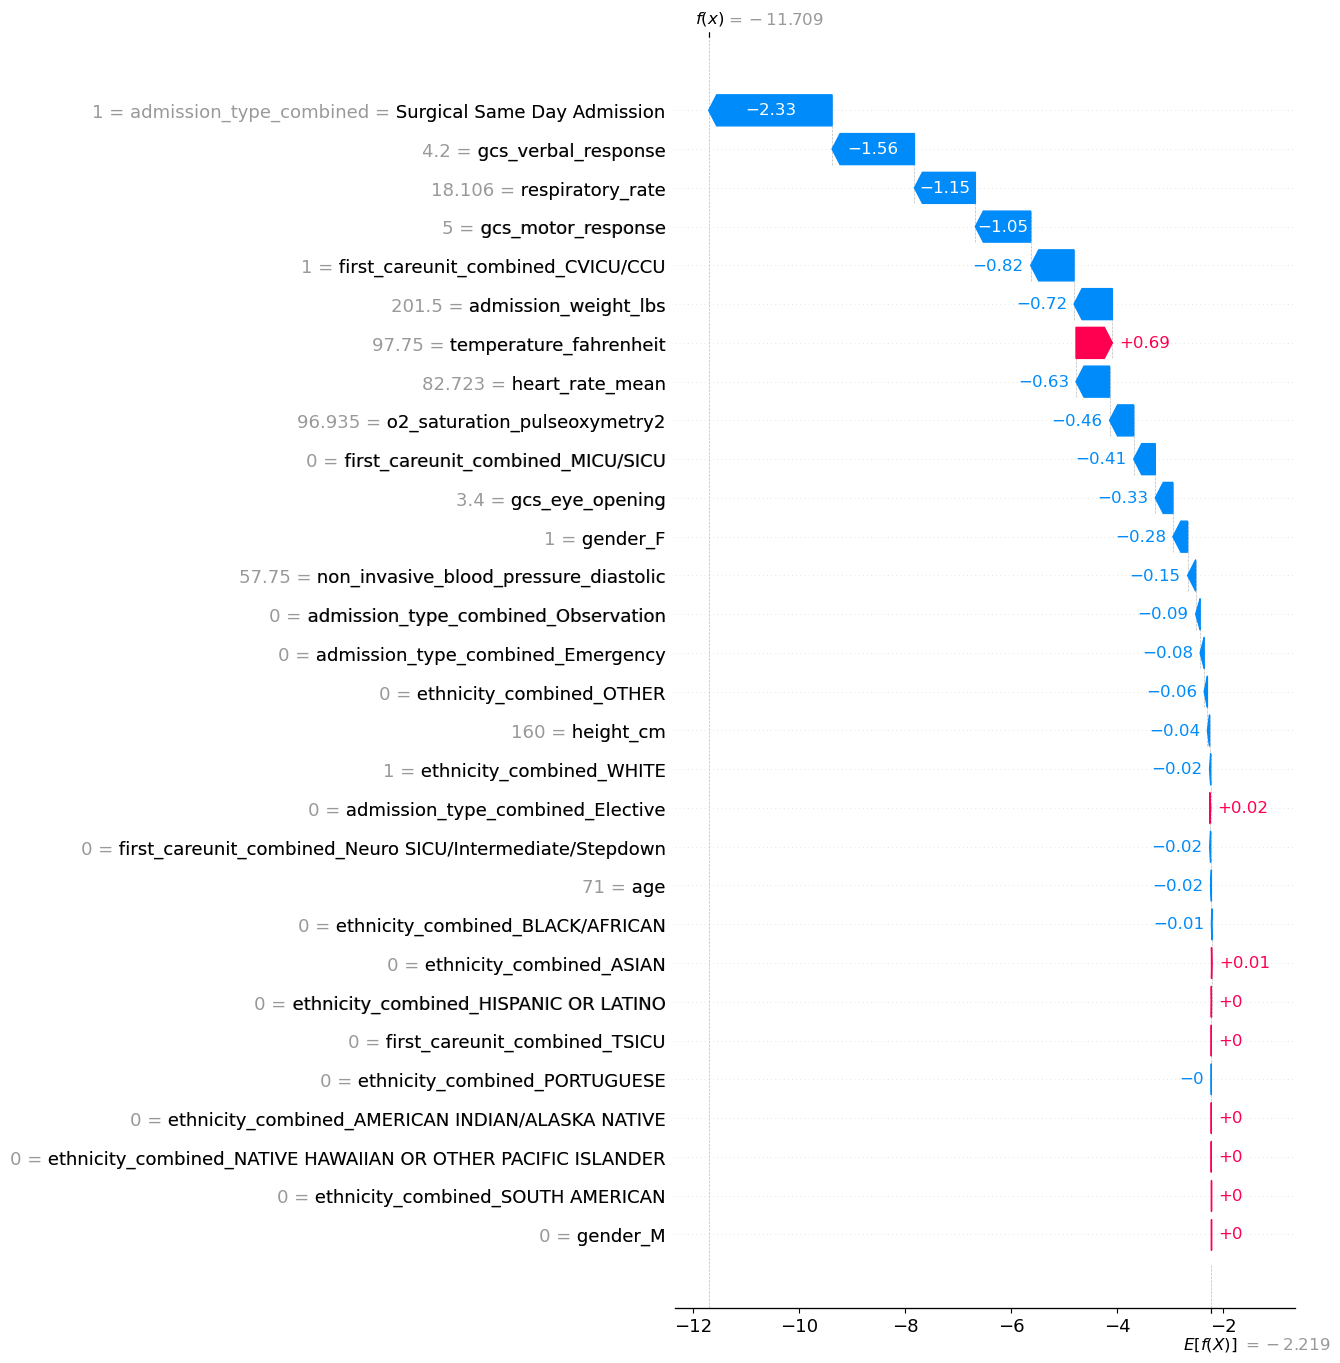

In [67]:
import pandas as pd
import shap
import xgboost as xgb

# Assume X_train, y_train, X_test are already defined and model is trained

# Rename the feature column
X_train.rename(columns={'admission_type_combined_Surgical Same Day Admission': 'admission_type_combined = Surgical Same Day Admission'}, inplace=True)
X_test.rename(columns={'admission_type_combined_Surgical Same Day Admission': 'admission_type_combined = Surgical Same Day Admission'}, inplace=True)

# Generate SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Create the waterfall plot
shap.plots.waterfall(shap_values[0], max_display=len(X_test.columns))

# If you want to save this plot, you can use plt.savefig as shown previously


In [80]:
import xgboost as xgb
from shapash.explainer.smart_explainer import SmartExplainer

# Assuming X_train, y_train, X_test are already defined and model is trained

best_params = grid_search.best_params_
model = xgb.XGBClassifier(**best_params)
model.fit(X_train, y_train)

# Initialize Shapash SmartExplainer with the model
xpl = SmartExplainer(model=model)

# Feature dictionary for renaming
feature_dict = {'admission_type_combined_Surgical Same Day Admission': 'admission_type_combined = Surgical Same Day Admission'}

# Fit the explainer with your data and rename features
xpl.compile(
    x=X_test,
    #features_dict=feature_dict
)

# Now you can use Shapash to display plots and summaries
# For instance, to display a web app:
xpl.run_app()

C:\Users\krishika.R\AppData\Roaming\Python\Python310\site-packages\xgboost\core.py:160: UserWarning:

[18:20:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.

C:\Users\krishika.R\AppData\Roaming\Python\Python310\site-packages\xgboost\core.py:160: UserWarning:

[18:20:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.

C:\Users\krishika.R\AppData\Roaming\Python\Python310\site-packages\xgboost\core.py:160: UserWarning:

[18:20:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-auto

INFO: Shap explainer type - <shap.explainers._tree.TreeExplainer object at 0x0000028C2FF59450>


INFO:root:Your Shapash application run on http://FACT-LAP-593:8050/
INFO:root:Use the method .kill() to down your app.


<CustomThread(Thread-12 (<lambda>), started 33308)>

Exception in thread Thread-12 (<lambda>):
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "C:\ProgramData\anaconda3\lib\site-packages\urllib3\util\connection.py", line 95, in create_connection
    raise err
  File "C:\ProgramData\anaconda3\lib\site-packages\urllib3\util\connection.py", line 85, in create_connection
    sock.connect(sa)
OSError: [WinError 10049] The requested address is not valid in its context

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "C:\ProgramData\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "C:\ProgramData\anaconda3\lib\site-packa

In [ ]:
import pandas as pd

# Example DataFrame
# Assume you have columns like 'admission_type_combined_Surgical', 'admission_type_combined_Medical', etc.
data = {
    'admission_type_combined_Surgical': [1, 0, 0],
    'admission_type_combined_Medical': [0, 1, 0],
    'admission_type_combined_Other': [0, 0, 1],
    # Other columns...
}

df = pd.DataFrame(data)

# Transform to a single column with categorical values
conditions = [
    df['admission_type_combined_Surgical'] == 1,
    df['admission_type_combined_Medical'] == 1,
    df['admission_type_combined_Other'] == 1
]

choices = ['Surgical', 'Medical', 'Other']

df['admission_type_combined'] = np.select(conditions, choices, default='Unknown')

# Now drop the original separate columns
df.drop(['admission_type_combined_Surgical', 'admission_type_combined_Medical', 'admission_type_combined_Other'], axis=1, inplace=True)

# Your df now has a single column for admission_type_combined with categories


In [72]:
import xgboost as xgb
from shapash.explainer.smart_explainer import SmartExplainer

# Assuming X_train, y_train, X_test are already defined and model is trained

# Train an XGBoost model (example)
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Initialize Shapash SmartExplainer
xpl = SmartExplainer()

# Fit the explainer with your model and data
xpl.compile(
    x=X_test,
    model=model,
    preprocessing=None  # Replace with your preprocessing if applicable
)

# Modify feature names
feature_dict = {
    'admission_type_combined_Surgical Same Day Admission': 'admission_type_combined = Surgical Same Day Admission'
    # Add other features as necessary
}
xpl.rename_features(feature_dict)

# Now you can use Shapash to display plots and summaries
# For instance, to display a web app:
xpl.run_app()


TypeError: SmartExplainer.__init__() missing 1 required positional argument: 'model'

In [63]:
import shap

# Create the SHAP explainer using the model
# Note: Your model should be already trained with `model.fit(X_train, y_train)`
explainer = shap.Explainer(model)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)

# Visualize the first prediction's explanation with a force plot
shap.initjs()  # Initialize JavaScript visualization in the notebook
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

[16:00:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


ValueError: visualize() can only display Explanation objects (or arrays of them)!

In [ ]:
# Summary plot for all features across all test data
shap.summary_plot(shap_values, X_test)

In [ ]:
# Waterfall plot for the first instance in the test set
shap.plots.waterfall(shap_values[0])

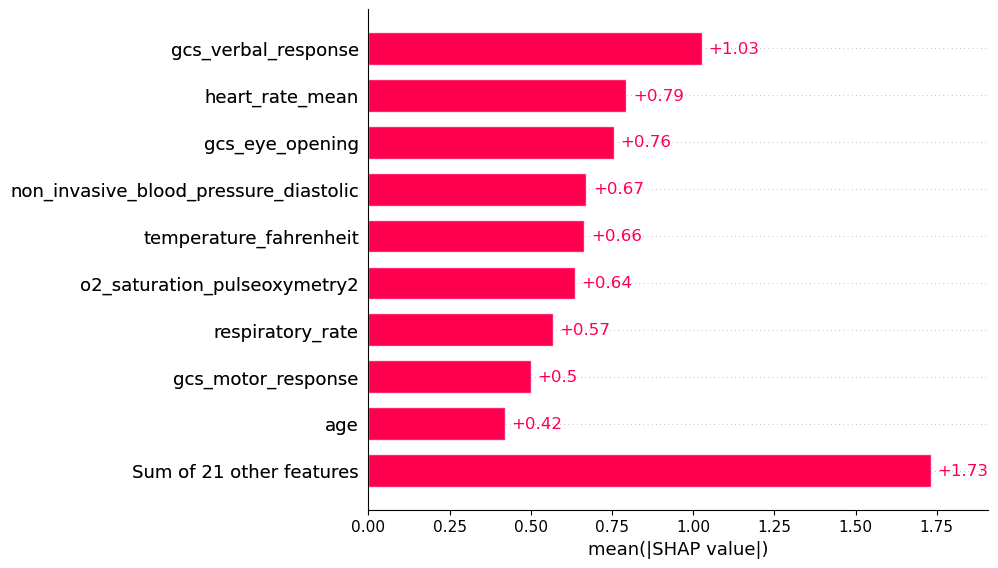

In [52]:
# Bar plot of mean SHAP values for all features
shap.plots.bar(shap_values)

In [85]:
import pandas as pd
import numpy as np

# Example DataFrame transformation
# Replace with your actual dataframe and column names
df = pd.DataFrame({
    'admission_type_combined_Surgical': [1, 0, 0],
    'admission_type_combined_Medical': [0, 1, 0],
    'admission_type_combined_Other': [0, 0, 1],
    # Other columns...
})

conditions = [
    df['admission_type_combined_Surgical'] == 1,
    df['admission_type_combined_Medical'] == 1,
    df['admission_type_combined_Other'] == 1
]

choices = ['Surgical', 'Medical', 'Other']

df['admission_type_combined'] = np.select(conditions, choices, default='Unknown')
df.drop(['admission_type_combined_Surgical', 'admission_type_combined_Medical', 'admission_type_combined_Other'], axis=1, inplace=True)

df['YourTargetColumn'] = [0,0,0]

In [ ]:
def data_connection_ed():
    # Load path to environment variables
    dotenv_path = 'C:/Users/krishika.R/Desktop/Streamlit/app_draft/database_config.env'
    load_dotenv(dotenv_path)
    
    # Database connection parameters
    db_name = os.environ.get('DB_NAME', 'factihealth') 
    db_user = os.environ.get('DB_USER', 'fh_user')
    db_password = os.environ.get('DB_PASSWORD', 'password')
    db_host = os.environ.get('DB_HOST', 'host')
    db_port = os.environ.get('DB_PORT', 5439)

    # Connection string
    conn_string = f"dbname={db_name} user={db_user} password={db_password} host={db_host} port={db_port}"

    # Load path for admissions master data sql query
    sql_file_path = r'C:/Users/krishika.R/Desktop/Streamlit/app_draft/queries/adt_query.sql'
    with open(sql_file_path, 'r') as file:
        sql_query = file.read()
        
        

    return master_data_ed


In [122]:
master_data.describe()

,subject_id,hadm_id,age,icu_los,hospital_expire_flag,heart_rate_mean,gcs_eye_opening,gcs_verbal_response,gcs_motor_response,non_invasive_blood_pressure_diastolic,non_invasive_blood_pressure_mean,respiratory_rate,temperature_fahrenheit,height_cm,admission_weight_lbs,mixed_venous_o2_sat,o2_saturation_pulseoxymetry2,ph_dipstick
count,7.300000e+01,7.300000e+01,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,72.000000,72.000000,73.000000,72.000000,42.000000,61.000000,8.000000,73.000000,25.000000
mean,1.511075e+07,2.516103e+07,60.068493,3.794237,0.041096,85.083047,3.461544,3.750475,5.465497,66.556116,80.189656,19.124999,98.517012,168.166667,178.282896,70.869048,97.116878,7.380333
std,2.956832e+06,2.645489e+06,19.483846,4.581493,0.199886,11.600552,0.559718,1.333661,0.930315,11.923736,12.555705,3.242796,0.650658,10.031455,49.292680,8.733900,1.489384,0.061790
min,1.016603e+07,2.004606e+07,20.000000,0.269769,0.000000,64.407407,1.125000,1.000000,1.000000,45.875000,59.250000,12.714286,97.520000,152.000000,107.800003,61.666667,93.878788,7.215000
25%,1.254922e+07,2.300402e+07,48.000000,1.214988,0.000000,73.250000,3.120000,2.929412,5.370370,59.411458,72.916667,16.909091,98.100001,157.750000,141.199997,64.773810,96.010638,7.350000
50%,1.558713e+07,2.469230e+07,62.000000,2.101389,0.000000,87.283237,3.571429,4.322581,5.736842,65.854626,80.000000,18.903226,98.300001,168.000000,169.399994,68.404762,97.060000,7.380000
75%,1.755841e+07,2.747324e+07,76.000000,3.899676,0.000000,93.727273,4.000000,5.000000,6.000000,72.461706,85.271429,20.973510,98.707954,175.000000,210.449997,76.750000,98.168831,7.410000
max,1.993839e+07,2.996693e+07,91.000000,26.046609,1.000000,114.542857,4.000000,5.000000,6.000000,112.750000,129.000000,31.047619,100.600002,188.000000,321.200012,84.000000,99.905660,7.500000


In [132]:
def pre_processing_mortality(data):
    mortality_data = master_data
    
    # dropping columns which are not required
    data.drop(['ph_dipstick','ethnicity','admission_type','mixed_venous_o2_sat','first_careunit','age_bucket','icu_los','edadmittime','edadmit_time'],axis = 1, inplace = True)

    # Cleaning the data by adding limits to remove unrealistic data due to human/techincal errors

    condition_1 = data['non_invasive_blood_pressure_diastolic'] > 200
    data.loc[condition_1, 'non_invasive_blood_pressure_diastolic'] = data.loc[condition_1, 'non_invasive_blood_pressure_mean']
    data = data[(data['heart_rate_mean'] >= 0) & (data['heart_rate_mean'] <= 500)]
    data = data[(data['respiratory_rate'] >= 0) & (data['respiratory_rate'] <= 100)]
    data = data[(data['temperature_fahrenheit'] >= 0) & (data['temperature_fahrenheit'] <= 250)]
    data = data[(data['admission_weight_lbs'] >= 0) & (data['admission_weight_lbs'] <= 1000)]
    data = data[(data['o2_saturation_pulseoxymetry2'] >= 0) & (data['o2_saturation_pulseoxymetry2'] <= 100)]
    data = data[(data['height_cm'] >= 0) & (data['height_cm'] <= 300)]
    data.drop(['non_invasive_blood_pressure_mean'],axis = 1, inplace = True)
    
    df_encoded = pd.get_dummies(data, columns=['admission_type_combined', 'first_careunit_combined','ethnicity_combined','gender'])
    
    mean_value = df_encoded['non_invasive_blood_pressure_diastolic'].mean()

    # Replace NaNs in the column with the calculated mean value
    df_encoded['non_invasive_blood_pressure_diastolic'].fillna(mean_value, inplace=True)
    df_encoded['gcs_eye_opening'].fillna(0, inplace=True)
    df_encoded['gcs_verbal_response'].fillna(0, inplace=True)
    df_encoded['gcs_motor_response'].fillna(0, inplace=True)
    
    df_encoded.drop(columns=['subject_id','hadm_id','hospital_expire_flag'],inplace = True)
    return df_encoded

In [133]:
data=master_data.copy()
data=pre_processing_mortality(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 1 to 70
Data columns (total 26 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   age                                                       40 non-null     int64  
 1   heart_rate_mean                                           40 non-null     float64
 2   gcs_eye_opening                                           40 non-null     float64
 3   gcs_verbal_response                                       40 non-null     float64
 4   gcs_motor_response                                        40 non-null     float64
 5   non_invasive_blood_pressure_diastolic                     40 non-null     float64
 6   respiratory_rate                                          40 non-null     float64
 7   temperature_fahrenheit                                    40 non-null     float64
 8   height_cm             

In [125]:
X = data.drop('hospital_expire_flag', axis=1)
y = data['hospital_expire_flag']

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5,8],
    # Add other parameters here
}

# Create a base model
xgb_classifier = xgb.XGBClassifier(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best parameters found:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Best accuracy found:  0.9428571428571428


In [30]:
import pickle
# Save the model to disk
filename = 'icu_patients_mortality_prediction.pkl'  # Change this path if you need to save it elsewhere
pickle.dump(grid_search.best_estimator_, open(filename, 'wb'))

print(f"Model saved to {filename}")

Model saved to icu_patients_mortality_prediction.pkl


In [142]:
input_data = data

In [144]:
with open('icu_patients_mortality_prediction.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)
 #   feature_names = pickle.load(model_file)

In [148]:
feature_names = ['Age',
'hospital_expire_flag',
'heart_rate_mean',
'gcs_eye_opening',
'gcs_verbal_response',
'gcs_motor_response',
'non_invasive_blood_pressure_diastolic',
'respiratory_rate',
'temperature_fahrenheit',
'height_cm',
'admission_weight_lbs',
'o2_saturation_pulseoxymetry2',
'admission_type_combined_Elective',
'admission_type_combined_Emergency',
'admission_type_combined_Observation',
'admission_type_combined_Surgical',
'first_careunit_combined_CVICU/CCU',
'first_careunit_combined_MICU/SICU',
'first_careunit_combined_Neuro',
'first_careunit_combined_TSICU',
'ethnicity_combined_AMERICAN',
'ethnicity_combined_ASIAN',
'ethnicity_combined_BLACK/AFRICAN',
'ethnicity_combined_HISPANIC',
'ethnicity_combined_NATIVE',
'ethnicity_combined_OTHER',
'ethnicity_combined_PORTUGUESE',
'ethnicity_combined_SOUTH',
'ethnicity_combined_WHITE',
'gender_F',
'gender_M'
]

In [149]:
with open('icu_patients_mortality_prediction.pkl', 'wb') as model_file:
    pickle.dump(loaded_model, model_file)
    pickle.dump(feature_names, model_file)

In [153]:
missing_columns

{'Age',
 'admission_type_combined_Surgical',
 'ethnicity_combined_AMERICAN',
 'ethnicity_combined_HISPANIC',
 'ethnicity_combined_NATIVE',
 'ethnicity_combined_PORTUGUESE',
 'ethnicity_combined_SOUTH',
 'first_careunit_combined_Neuro',
 'hospital_expire_flag'}

In [152]:
# Check if input_data contains all feature columns
missing_columns = set(feature_names) - set(input_data.columns)

if missing_columns:
    # Add missing columns and fill them with zeros
    for column in missing_columns:
        data[column] = 0  # Fill with zeros

# Make predictions using the loaded model and input_data
predictions = loaded_model.predict(data)

ValueError: feature_names mismatch: ['age', 'heart_rate_mean', 'gcs_eye_opening', 'gcs_verbal_response', 'gcs_motor_response', 'non_invasive_blood_pressure_diastolic', 'respiratory_rate', 'temperature_fahrenheit', 'height_cm', 'admission_weight_lbs', 'o2_saturation_pulseoxymetry2', 'admission_type_combined_Elective', 'admission_type_combined_Emergency', 'admission_type_combined_Observation', 'admission_type_combined_Surgical Same Day Admission', 'first_careunit_combined_CVICU/CCU', 'first_careunit_combined_MICU/SICU', 'first_careunit_combined_Neuro SICU/Intermediate/Stepdown', 'first_careunit_combined_TSICU', 'ethnicity_combined_AMERICAN INDIAN/ALASKA NATIVE', 'ethnicity_combined_ASIAN', 'ethnicity_combined_BLACK/AFRICAN', 'ethnicity_combined_HISPANIC OR LATINO', 'ethnicity_combined_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'ethnicity_combined_OTHER', 'ethnicity_combined_PORTUGUESE', 'ethnicity_combined_SOUTH AMERICAN', 'ethnicity_combined_WHITE', 'gender_F', 'gender_M'] ['age', 'heart_rate_mean', 'gcs_eye_opening', 'gcs_verbal_response', 'gcs_motor_response', 'non_invasive_blood_pressure_diastolic', 'respiratory_rate', 'temperature_fahrenheit', 'height_cm', 'admission_weight_lbs', 'o2_saturation_pulseoxymetry2', 'admission_type_combined_Elective', 'admission_type_combined_Emergency', 'admission_type_combined_Observation', 'admission_type_combined_Surgical Same Day Admission', 'first_careunit_combined_CVICU/CCU', 'first_careunit_combined_MICU/SICU', 'first_careunit_combined_Neuro SICU/Intermediate/Stepdown', 'first_careunit_combined_TSICU', 'ethnicity_combined_ASIAN', 'ethnicity_combined_BLACK/AFRICAN', 'ethnicity_combined_HISPANIC OR LATINO', 'ethnicity_combined_OTHER', 'ethnicity_combined_WHITE', 'gender_F', 'gender_M', 'first_careunit_combined_Neuro', 'ethnicity_combined_NATIVE', 'hospital_expire_flag', 'admission_type_combined_Surgical', 'Age', 'ethnicity_combined_AMERICAN', 'ethnicity_combined_HISPANIC', 'ethnicity_combined_SOUTH', 'ethnicity_combined_PORTUGUESE']
expected ethnicity_combined_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER, ethnicity_combined_SOUTH AMERICAN, ethnicity_combined_AMERICAN INDIAN/ALASKA NATIVE in input data
training data did not have the following fields: first_careunit_combined_Neuro, ethnicity_combined_NATIVE, hospital_expire_flag, admission_type_combined_Surgical, ethnicity_combined_AMERICAN, Age, ethnicity_combined_HISPANIC, ethnicity_combined_SOUTH

In [118]:
# ... (Previous code for training and hyperparameter tuning)

# Get the best estimator (model with best hyperparameters)
best_xgb_classifier = grid_search.best_estimator_

# Use the best model to make predictions on the test set
y_pred = best_xgb_classifier.predict(X_test)

# Obtain prediction probabilities for each class
# Here, we use the predict_proba method
y_pred_probabilities = best_xgb_classifier.predict_proba(X_test)

# y_pred contains the predicted class labels (0 or 1)
# y_pred_probabilities contains the prediction probabilities for each class


In [124]:
y_pred_probabilities

7246

In [123]:
class_names = ['Alive', 'Dead']
probabilities_df = pd.DataFrame(y_pred_probabilities, columns=class_names)
percent_probabilities = probabilities_df * 100
pred_df=percent_probabilities.reset_index().rename(columns={'index': 'Index'})
pred_df

,Index,Alive,Dead
0,0,99.885284,0.114713
1,1,99.932114,0.067884
2,2,99.962387,0.037615
3,3,99.914314,0.085690
4,4,16.199011,83.800987
...,...,...,...
7241,7241,99.999733,0.000271
7242,7242,83.149063,16.850939
7243,7243,99.227135,0.772865
7244,7244,99.998291,0.001710


In [121]:
orig_df=master_data.reset_index().rename(columns={'index': 'Index'})
orig_df=orig_df[['Index', 'subject_id','age','edadmit_time','ethnicity']]
orig_df.tail(5)

,Index,subject_id,age,edadmit_time,ethnicity
68,68,16304004,48,2023-04-25,HISPANIC OR LATINO
69,69,16288431,81,2023-05-09,WHITE
70,70,16648184,74,2023-05-10,WHITE
71,71,16030932,84,2023-05-12,ASIAN
72,72,12620045,84,2023-05-17,OTHER
